# Reward Model Training with PEFT

The process of fine-tuning a `GPT-2` model to act as a **reward model**. The goal is to train a model that can score text completions, assigning a higher score to responses preferred by humans.

### Workflow
1.  **Data Preparation**: Load a pre-processed dataset of "chosen" and "rejected" responses.
2.  **Model Configuration**: Set up a `GPT2ForSequenceClassification` model.
3.  **Efficient Fine-Tuning**: Use **Parameter-Efficient Fine-Tuning (PEFT)** with **LoRA** to train only a small fraction of the model's parameters, saving significant computational resources.
4.  **Training**: Utilize the `RewardTrainer` from the `trl` library, which is specifically designed for this task.
5.  **Evaluation**: Assess the final model's ability to correctly identify the "chosen" response over the "rejected" one to measure its performance.

In [1]:
# !pip install transformers==4.43.4
# !pip install torch
# # !pip install trl
# !pip install trl==0.11
# !pip install peft
# !pip install --upgrade tqdm

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments
from peft import LoraConfig, TaskType
from trl import RewardTrainer
from trl import RewardConfig
import json
import matplotlib.pyplot as plt
from data_pipeline import prepare_reward_dataset

In [3]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token # Set pad token

model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=1)
model.config.pad_token_id = model.config.eos_token_id # Configure model pad token

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=1, bias=False)
)

In [5]:
processed_dataset, filtered_dataset = prepare_reward_dataset(
    tokenizer=tokenizer,
    max_length=1024,
    test_size=0.1
)

Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Formatting prompt-response pairs...


Map:   0%|          | 0/33143 [00:00<?, ? examples/s]

Filtering examples longer than a heuristic max length...


Filter:   0%|          | 0/33143 [00:00<?, ? examples/s]

Filtered out 56 examples.
Splitting data into 90% train and 10% test...
Tokenizing dataset splits...


Map:   0%|          | 0/29778 [00:00<?, ? examples/s]

Map:   0%|          | 0/3309 [00:00<?, ? examples/s]

Data preparation complete.


In [6]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 29778
    })
    test: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 3309
    })
})

In [7]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected'],
        num_rows: 29778
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected'],
        num_rows: 3309
    })
})

In [10]:
print("\n" + "="*50)
print("INSPECTING RETURNED DATASETS")
print("="*50 + "\n")

# --- Inspecting Tokenized Dataset ---
print("--- 1. Tokenized Dataset (for Model Training) ---")
print(processed_dataset)
print("\nFirst example from the 'train' split (tokenized):")
print(processed_dataset['train'][0])
print("\nFirst example from the 'test' split (tokenized):")
print(processed_dataset['test'][0])


# --- Inspecting Filtered Text Dataset ---
print("\n\n--- 2. Filtered Text Dataset (for Inspection) ---")
print(filtered_dataset)
print("\nFirst example from the 'train' split (text):")
print(filtered_dataset['train'][0])
print("\nFirst example from the 'test' split (text):")
print(filtered_dataset['test'][0])


INSPECTING RETURNED DATASETS

--- 1. Tokenized Dataset (for Model Training) ---
DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 29778
    })
    test: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 3309
    })
})

First example from the 'train' split (tokenized):
{'input_ids_chosen': [198, 198, 20490, 25, 1374, 460, 314, 3551, 257, 13206, 3002, 3850, 329, 257, 1693, 3586, 13, 198, 198, 48902, 25, 22183, 257, 13206, 3002, 3850, 329, 257, 1693, 3586, 9018, 21292, 534, 5981, 4678, 290, 6461, 326, 787, 345, 262, 7306, 4540, 329, 262, 2292, 13, 6889, 1654, 345, 10176, 17131, 329, 262, 2597, 290, 905, 345, 1833, 262, 1664, 3968, 13, 6889, 1654, 284, 2267, 262, 1664, 290, 5977, 257, 27571, 3850, 11, 14928, 14276, 3303, 13, 13786, 6096, 286, 703, 345, 423, 3750, 3675, 262, 1693, 338

In [12]:
first_train_example = processed_dataset['train'][0]

chosen_ids = first_train_example['input_ids_chosen']
rejected_ids = first_train_example['input_ids_rejected']

decoded_chosen = tokenizer.decode(chosen_ids, skip_special_tokens=True)
decoded_rejected = tokenizer.decode(rejected_ids, skip_special_tokens=True)

print("\n\n" + "="*50)
print("DECODING TOKENS BACK TO TEXT")
print("="*50 + "\n")

print("--- Decoding the first 'train' example ---")

print("\nDecoded 'chosen' text:")
print(f"{decoded_chosen}")

print("\nDecoded 'rejected' text:")
print(f"{decoded_rejected}")



DECODING TOKENS BACK TO TEXT

--- Decoding the first 'train' example ---

Decoded 'chosen' text:


Human: How can I write a compelling cover letter for a job application.

Assistant: Writing a compelling cover letter for a job application involves highlighting your relevant skills and experiences that make you the ideal candidate for the position. Make sure you demonstrate enthusiasm for the role and show you understand the company culture. Make sure to research the company and craft a tailored letter, avoiding generic language. Give examples of how you have gone beyond the job's requirements in the past, highlighting your commitment and dedication to your work. Finally, make sure to proofread and edit your letter for any typos or errors before submitting it for consideration.

Decoded 'rejected' text:


Human: How can I write a compelling cover letter for a job application.

Assistant: Would you consider a cover letter “cover letter.


## LoRA Configuration

In [15]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]
)

## Training Arguments

In [16]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
GPU name: NVIDIA A10G


In [22]:
training_args = RewardConfig(
    output_dir="./reward_model_output_new",
    num_train_epochs=1,
    per_device_train_batch_size=4,    
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,    
    learning_rate=1.41e-5,            
    logging_steps=5,
    eval_strategy="steps",      
    eval_steps=150,             
    save_steps=150,             
    save_total_limit=2,         
    load_best_model_at_end=True,
)

## Initialize RewardTrainer

In [23]:
trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['test'],
    peft_config=peft_config
)

## Training 

In [24]:
output_dir="./reward_model_output_new"

In [25]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
150,0.591600,0.654352,0.651556
300,0.342800,0.351671,0.899365
450,0.204100,0.165579,0.944394
600,0.075700,0.094422,0.964037
750,0.080500,0.073071,0.968873
900,0.069100,0.060323,0.973708
1050,0.103700,0.058041,0.974615
1200,0.034500,0.053459,0.976126
1350,0.114100,0.051129,0.977335
1500,0.044300,0.049154,0.977032


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.6809, 0.3191] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.8534, 0.1466] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9727, 0.0273] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9922, 0.0078] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9994, 0.0006] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9997, 0.0003] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9989, 0.0011] │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

TrainOutput(global_step=1861, training_loss=0.17897734041378294, metrics={'train_runtime': 6092.0275, 'train_samples_per_second': 4.888, 'train_steps_per_second': 0.305, 'total_flos': 0.0, 'train_loss': 0.17897734041378294, 'epoch': 0.9998656816655473})

In [27]:
# last_checkpoint = "./reward_model_output_new/checkpoint-300"
# trainer.train(resume_from_checkpoint=last_checkpoint)

In [28]:
# Save the model
trainer.save_model(output_dir)

In [29]:
# Evaluate the model
metrics = trainer.evaluate()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: What is the best way to cook a whole   │ Human: What is the best way to cook a whole  │                  │
│ chicken.                                      │ chicken.                                     │                  │
│                                               │                                              │                  │
│ Assistant: The best way to cook a whole       │ Assistant: Make sure the chicken is meaty,   │                  │
│ chicken is to roast it in the oven. Preheat   │ you can break it into pieces, and put them   │                  │
│ the oven to 375 degrees Fahrenheit, then      │ into a large resealable container.  Top with │                  │
│ place the chicken in a roasting pan or dish.  │ lemon or lime:                               │                  │
│ Rub the chicken with your favorite            │                                              │                  │
│ seasonings, and then cook it for about an     │ ----                                         │                  │
│ hour and twenty minutes or until a meat       │                                              │                  │
│ thermometer inserted into the thigh reads 165 │ [For the chicken]                            │                  │
│ degrees Fahrenheit. Allow the chicken to rest │                                              │                  │
│ for about 15 minutes, then serve and enjoy.   │ [Prep]                                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [Put the chicken into]                       │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cooking a whole chicken]                    │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │                                              │                  │
│                                               │ [Cook the chicken]                           │                  │
│                                               │                                              │                  │
│                                               │ [For the sauce]                              │                  │
│                                               │       

In [30]:
print(metrics)

{'eval_loss': 0.04697125777602196, 'eval_accuracy': 0.9794499848896948, 'eval_runtime': 174.4542, 'eval_samples_per_second': 18.968, 'eval_steps_per_second': 4.746, 'epoch': 0.9998656816655473}


In [31]:
model.config.save_pretrained("./backup")

In [32]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT2ForSequenceClassification.from_pretrained("./reward_model_output_new", num_labels=1).to(DEVICE)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
log_file = "reward_model_output_new/checkpoint-1861/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# --- Prepare lists to store all metrics ---
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
eval_accuracies = []

# --- Iterate through the log history and extract all data ---
for log in logs["log_history"]:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    
    elif "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])
        
        if "eval_accuracy" in log:
            eval_accuracies.append(log["eval_accuracy"])

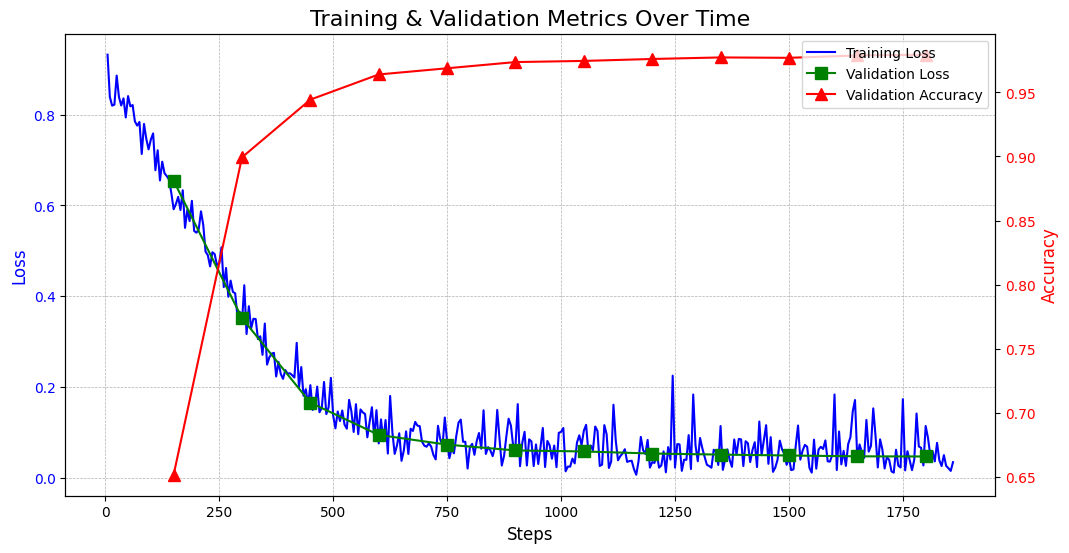

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(train_steps, train_losses, 'b-', label="Training Loss")
ax1.plot(eval_steps, eval_losses, 'g-s', label="Validation Loss", markersize=8) 
ax1.set_xlabel("Steps", fontsize=12)
ax1.set_ylabel("Loss", color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(eval_steps, eval_accuracies, 'r-^', label="Validation Accuracy", markersize=8) 
ax2.set_ylabel("Accuracy", color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Training & Validation Metrics Over Time", fontsize=16)

# Combine legends from both axes into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

## Evaluation

In [37]:
text1 = filtered_dataset['train']['prompt_chosen'][0]
print(text1)



Human: How can I write a compelling cover letter for a job application.

Assistant: Writing a compelling cover letter for a job application involves highlighting your relevant skills and experiences that make you the ideal candidate for the position. Make sure you demonstrate enthusiasm for the role and show you understand the company culture. Make sure to research the company and craft a tailored letter, avoiding generic language. Give examples of how you have gone beyond the job's requirements in the past, highlighting your commitment and dedication to your work. Finally, make sure to proofread and edit your letter for any typos or errors before submitting it for consideration.


In [41]:
inputs = tokenizer(text1, return_tensors="pt", padding=True, truncation=True, max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_1 = outputs.logits
print("Score :", logit_1)

Score : tensor([[4.2894]], device='cuda:0')


In [42]:
text2 = filtered_dataset['train']['prompt_rejected'][0]
print(text2)



Human: How can I write a compelling cover letter for a job application.

Assistant: Would you consider a cover letter “cover letter.


In [43]:
inputs = tokenizer(text2, return_tensors="pt", padding=True, truncation=True, max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_2 = outputs.logits
print("Score :",logit_2)

Score : tensor([[-7.7175]], device='cuda:0')


In [44]:
if logit_1 > logit_2:
    print("--------selected---------")
    print(text1, logit_1.detach().item())
    print("--------rejected---------")
    print(text2, logit_2.detach().item())
else:
    print("selected ")
    print(text2, logit_2.detach().item())
    print("rejected")
    print(text1, logit_1.detach().item())

--------selected---------


Human: How can I write a compelling cover letter for a job application.

Assistant: Writing a compelling cover letter for a job application involves highlighting your relevant skills and experiences that make you the ideal candidate for the position. Make sure you demonstrate enthusiasm for the role and show you understand the company culture. Make sure to research the company and craft a tailored letter, avoiding generic language. Give examples of how you have gone beyond the job's requirements in the past, highlighting your commitment and dedication to your work. Finally, make sure to proofread and edit your letter for any typos or errors before submitting it for consideration. 4.289446830749512
--------rejected---------


Human: How can I write a compelling cover letter for a job application.

Assistant: Would you consider a cover letter “cover letter. -7.7175116539001465


In [45]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits.squeeze().item()
    
    return logits

In [46]:
# Function to compare two texts
def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        return text1
    else:
        return text2

In [47]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected'],
        num_rows: 29778
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected'],
        num_rows: 3309
    })
})

In [43]:
correct_selections = 0

for chosen, rejected in zip(filtered_dataset['train']['prompt_chosen'][:1000],
                            filtered_dataset['train']['prompt_rejected'][:1000]):
    selected_text = compare_texts(chosen, rejected)
    
    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

In [44]:
accuracy = correct_selections / N
print("Accuracy:", accuracy)

Accuracy: 0.894


## Base and FineTuned Model Performance

In [48]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [49]:
finetuned_model = GPT2ForSequenceClassification.from_pretrained("./reward_model_output_new", num_labels=1).to(DEVICE)
finetuned_model.eval()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropou

In [50]:
base_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=1).to(DEVICE)
base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.eval()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=1, bias=False)
)

In [51]:
def predict_and_get_logits(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.logits.squeeze().item()

def compare_texts(text1, text2, model, tokenizer, device):
    logit1 = predict_and_get_logits(text1, model, tokenizer, device)
    logit2 = predict_and_get_logits(text2, model, tokenizer, device)
    return text1 if logit1 > logit2 else text2

In [54]:
def evaluate_model(model_to_test, dataset):
    correct_selections = 0
    num_samples = len(dataset['prompt_chosen'])
    
    for i in range(num_samples):
        chosen = dataset['prompt_chosen'][i]
        rejected = dataset['prompt_rejected'][i]
        
        selected_text = compare_texts(chosen, rejected, model_to_test, tokenizer, DEVICE)
        
        if selected_text == chosen:
            correct_selections += 1
            
    accuracy = correct_selections / num_samples
    return accuracy

In [55]:
filtered_dataset['test']

Dataset({
    features: ['prompt', 'chosen', 'rejected', 'prompt_chosen', 'prompt_rejected'],
    num_rows: 3309
})

In [56]:
eval_dataset = filtered_dataset['test']

finetuned_accuracy = evaluate_model(finetuned_model, eval_dataset)
base_model_accuracy = evaluate_model(base_model, eval_dataset)

print("\n---Final Comparison ---")
print(f"Fine-Tuned Model Accuracy: {finetuned_accuracy:.4f}")
print(f"Base Model Accuracy:         {base_model_accuracy:.4f}")


---Final Comparison ---
Fine-Tuned Model Accuracy: 0.9794
Base Model Accuracy:         0.1792


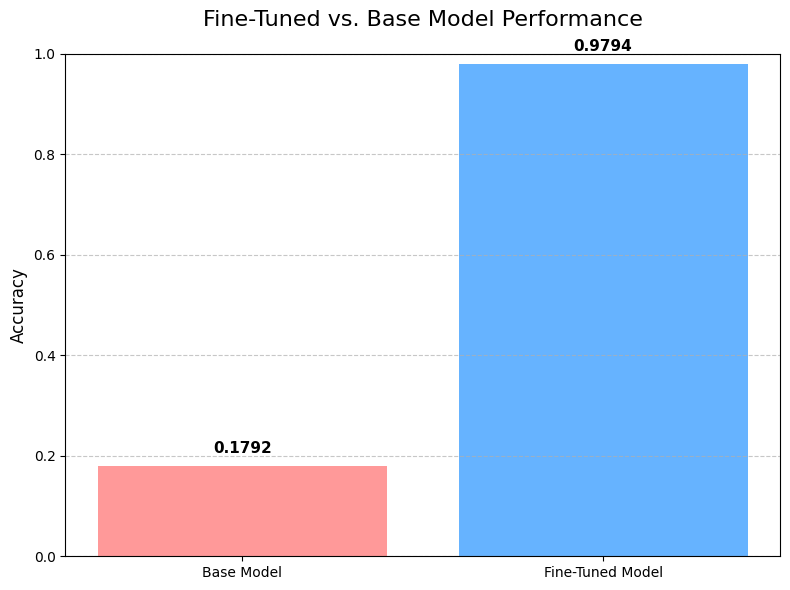

In [60]:
model_names = ['Base Model', 'Fine-Tuned Model']
accuracies = [base_model_accuracy, finetuned_accuracy]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=colors)

plt.ylabel('Accuracy', fontsize=12)
plt.title('Fine-Tuned vs. Base Model Performance', fontsize=16, pad=20)  # <-- add space
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.4f}', 
             ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()  
plt.show()